In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model
import numpy as np
import ast

2025-09-03 17:19:41.507713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756919981.749511      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756919981.822322      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/olive-oil/Fluorescence_olive_oil_dataset.csv')


In [3]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,Sample,Repetition,Led,Data,Quality,FAEES,K232,K270,Acidity,Peroxide Index
0,0,D73,19,2,"[1490.0,1521.0,1544.0,1509.0,1491.0,1574.0,157...",EXTRA,15.0,1.66,0.14,0.20,8.9
1,1,D35,19,2,"[1487.0,1518.0,1537.0,1506.0,1485.0,1562.0,156...",EXTRA,8.0,1.63,0.12,0.17,6.4
2,2,D77,3,1,"[1490.0,1528.0,1541.0,1509.0,1486.0,1577.0,157...",VIRGEN,26.0,1.74,0.13,0.24,10.4
3,3,D09,8,2,"[1486.0,1517.0,1531.0,1501.0,1483.0,1558.0,155...",LAMPANTE,NaN,NaN,NaN,NaN,NaN
4,4,D35,14,1,"[1492.0,1515.0,1534.0,1505.0,1487.0,1568.0,156...",EXTRA,8.0,1.63,0.12,0.17,6.4


In [4]:
df.describe()

,Unnamed: 0,Repetition,Led,FAEES,K232,K270,Acidity,Peroxide Index
count,960.000000,960.000000,960.000000,720.000000,720.000000,720.000000,880.000000,840.000000
mean,541.183333,9.500000,1.500000,18.666667,1.591944,0.132333,0.461364,8.009524
std,312.607160,5.769287,0.500261,11.183139,0.116583,0.015969,0.513697,3.699938
min,0.000000,0.000000,1.000000,7.000000,1.403000,0.108000,0.160000,4.600000
25%,269.750000,4.750000,1.000000,9.000000,1.537000,0.120000,0.180000,5.000000
50%,545.500000,9.500000,1.500000,15.500000,1.630000,0.130000,0.255000,8.400000
75%,812.250000,14.250000,2.000000,26.000000,1.630000,0.140000,0.400000,8.900000
max,1081.000000,19.000000,2.000000,47.000000,1.910000,0.170000,2.160000,22.000000


In [5]:
df = df.drop(['Unnamed: 0', 'Sample'], axis=1)

In [6]:
df["Led"]=df["Led"].replace({1:0,2:1})

In [7]:
data_to_array=df["Data"].apply(lambda x: ast.literal_eval(x))

In [8]:
data_expanded = pd.DataFrame(data_to_array.to_list())
data_expanded_cols=data_expanded.columns
df = df.drop(columns=['Data']).reset_index(drop=True)
df = pd.concat([df, data_expanded], axis=1)

In [9]:
df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Repetition,Led,Quality,FAEES,K232,K270,Acidity,Peroxide Index,0,1,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,19,1,EXTRA,15.0,1.66,0.14,0.20,8.9,1490.0,1521.0,...,1641.0,1590.0,1595.0,1633.0,1545.0,1594.0,1614.0,1490.0,1605.0,1583.0
1,19,1,EXTRA,8.0,1.63,0.12,0.17,6.4,1487.0,1518.0,...,1626.0,1586.0,1588.0,1619.0,1547.0,1586.0,1610.0,1488.0,1598.0,1574.0
2,3,0,VIRGEN,26.0,1.74,0.13,0.24,10.4,1490.0,1528.0,...,1643.0,1592.0,1596.0,1631.0,1550.0,1596.0,1616.0,1486.0,1598.0,1579.0
3,8,1,LAMPANTE,NaN,NaN,NaN,NaN,NaN,1486.0,1517.0,...,1611.0,1574.0,1577.0,1602.0,1534.0,1572.0,1593.0,1483.0,1579.0,1565.0
4,14,0,EXTRA,8.0,1.63,0.12,0.17,6.4,1492.0,1515.0,...,1611.0,1569.0,1573.0,1605.0,1535.0,1573.0,1592.0,1476.0,1583.0,1560.0


In [10]:
categorical_columns=["Repetition","Quality","Led"]
numerical_columns = ["FAEES", "K232", "K270", "Acidity", "Peroxide Index"]
numerical_columns.extend(data_expanded_cols)

In [11]:
df.isna().sum()

Repetition      0
Led             0
Quality         0
FAEES         240
K232          240
             ... 
1019            0
1020            0
1021            0
1022            0
1023            0
Length: 1032, dtype: int64

In [12]:
df[numerical_columns].skew().head(6)

FAEES             1.091297
K232              0.713190
K270              0.713331
Acidity           2.371726
Peroxide Index    2.414490
0                 0.341968
dtype: float64

In [13]:
cols_to_median=['FAEES', 'K232', 'K270', 'Acidity', 'Peroxide Index']
df[cols_to_median]=df[cols_to_median].fillna(df[cols_to_median].median())

In [14]:
df.isna().sum()

Repetition    0
Led           0
Quality       0
FAEES         0
K232          0
             ..
1019          0
1020          0
1021          0
1022          0
1023          0
Length: 1032, dtype: int64

Encoder

In [15]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df[['Quality']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Quality']))
df2 = df.drop(columns=['Quality']).reset_index(drop=True)
df2 = pd.concat([df2, encoded_df], axis=1)

In [16]:
df2.head()

,Repetition,Led,FAEES,K232,K270,Acidity,Peroxide Index,0,1,2,...,1017,1018,1019,1020,1021,1022,1023,Quality_EXTRA,Quality_LAMPANTE,Quality_VIRGEN
0,19,1,15.0,1.66,0.14,0.200,8.9,1490.0,1521.0,1544.0,...,1633.0,1545.0,1594.0,1614.0,1490.0,1605.0,1583.0,1.0,0.0,0.0
1,19,1,8.0,1.63,0.12,0.170,6.4,1487.0,1518.0,1537.0,...,1619.0,1547.0,1586.0,1610.0,1488.0,1598.0,1574.0,1.0,0.0,0.0
2,3,0,26.0,1.74,0.13,0.240,10.4,1490.0,1528.0,1541.0,...,1631.0,1550.0,1596.0,1616.0,1486.0,1598.0,1579.0,0.0,0.0,1.0
3,8,1,15.5,1.63,0.13,0.255,8.4,1486.0,1517.0,1531.0,...,1602.0,1534.0,1572.0,1593.0,1483.0,1579.0,1565.0,0.0,1.0,0.0
4,14,0,8.0,1.63,0.12,0.170,6.4,1492.0,1515.0,1534.0,...,1605.0,1535.0,1573.0,1592.0,1476.0,1583.0,1560.0,1.0,0.0,0.0


In [17]:
train_data, test_data = train_test_split(df2, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [18]:
num_cols = df2.columns[(df2.nunique() != 2)] 
num_cols

Index([    'Repetition',          'FAEES',           'K232',           'K270',
              'Acidity', 'Peroxide Index',                0,                1,
                      2,                3,
       ...
                   1014,             1015,             1016,             1017,
                   1018,             1019,             1020,             1021,
                   1022,             1023],
      dtype='object', length=1030)

In [19]:
def scale_data(data,cols):
    data_to_scale=data[cols]
    min_val = tf.reduce_min(data[cols]).numpy()
    max_val= tf.reduce_max(data[cols]).numpy()
    data[cols] = (data[cols] - min_val) / (max_val - min_val)
    data = tf.cast(data, tf.float32)
    return data

In [20]:
train_data=scale_data(train_data,num_cols)
test_data=scale_data(test_data,num_cols)
val_data=scale_data(val_data,num_cols)
train_data = tf.cast(train_data, tf.float32)
test_data=tf.cast(test_data, tf.float32)
val_data=tf.cast(val_data, tf.float32)

2025-09-03 17:20:02.172544: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
X_train = train_data[:, :-3]  
y_train = train_data[:, -3:]  

X_test = test_data[:, :-3]  
y_test = test_data[:, -3:] 

X_val= val_data[:, :-3]
y_val= val_data[:,-3:]

In [22]:
class QualityClassifier(tf.keras.Model):
  def __init__(self):
    super(QualityClassifier, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(1024, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64,activation="relu"),
        ])

    self.classifier = tf.keras.Sequential([
        layers.Dense(32, activation="relu"),  
        layers.Dense(3, activation="softmax"),  
        ])
        
  def call(self, x):
    encoded = self.encoder(x)
    class_probs = self.classifier(encoded)
    return class_probs

autoencoder = QualityClassifier()
autoencoder.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = autoencoder.fit(
          X_train,
          y_train, 
          epochs=90, 
          batch_size=64,
          validation_data=(X_val, y_val),
          shuffle=True,
        )

Epoch 1/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3373 - loss: 1.0853 - val_accuracy: 0.6104 - val_loss: 0.9628
Epoch 2/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5890 - loss: 0.9352 - val_accuracy: 0.5714 - val_loss: 0.8300
Epoch 3/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5967 - loss: 0.7755 - val_accuracy: 0.6169 - val_loss: 0.7679
Epoch 4/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6291 - loss: 0.7036 - val_accuracy: 0.6494 - val_loss: 0.6297
Epoch 5/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6716 - loss: 0.6274 - val_accuracy: 0.6104 - val_loss: 0.6019
Epoch 6/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6445 - loss: 0.6051 - val_accuracy: 0.6623 - val_loss: 0.5781
Epoch 7/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6569 - loss: 0.6066 - val_accuracy: 0.6429 - val_loss: 0.6902
Epoch 8/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6304 - loss: 0.6631 - val_accuracy: 0.6429 - v

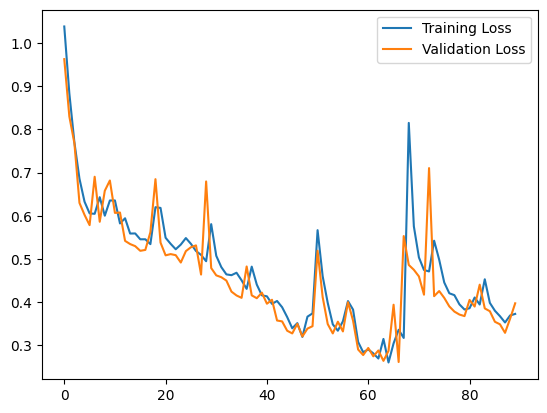

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [25]:
predictions=autoencoder.predict(X_test)
y_pred = to_categorical(np.argmax(predictions, axis=1), num_classes=3)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [26]:
predictions=autoencoder.predict(X_test)
y_pred = to_categorical(np.argmax(predictions, axis=1), num_classes=3)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
